In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
CSV_PATH = Path("..") / "research_logs" / "phi35-mams-atsa-8.csv"
OUT_DIR = Path("figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
df = pd.read_csv(CSV_PATH)
df = df.sort_values("step").reset_index(drop=True)

df.head()

,train/total_loss,train/l_absa,train/l_rec,train/mse_loss,train/alpha,train/beta,train/lr,step
0,6.00000,8.9375,4.90625,1.718750,1.000000,0.100000,0.000000e+00,0.0
1,7.93750,9.6875,6.78125,1.984375,0.999838,0.100182,2.427184e-07,5.0
2,5.56250,5.7500,4.78125,1.867188,0.999676,0.100364,4.045307e-07,10.0
3,6.25000,9.6875,5.09375,1.812500,0.999515,0.100546,6.472492e-07,15.0
4,6.78125,10.5625,5.53125,1.765625,0.999353,0.100728,8.090615e-07,20.0


In [4]:
x = df["step"]

In [5]:
import seaborn as sns
sns.set_theme(style="whitegrid", context="talk")

In [6]:
W = 21  

loss_cols = ["train/total_loss", "train/l_absa", "train/l_rec", "train/mse_loss"]
df_losses = df[["step"] + loss_cols].copy()
df_losses.loc[df_losses["train/l_rec"] == 0, "train/l_rec"] = pd.NA

# raw -> long
raw_long = df_losses.melt(id_vars="step", var_name="metric", value_name="value")
raw_long["kind"] = "raw"

# smoothed (rolling mean по каждой метрике)
sm = df_losses.copy()
for c in loss_cols:
    sm[c] = sm[c].rolling(W, center=True, min_periods=1).mean()

sm_long = sm.melt(id_vars="step", var_name="metric", value_name="value")
sm_long["kind"] = f"smoothed (W={W})"

loss_long = pd.concat([raw_long, sm_long], ignore_index=True)
loss_long["metric"] = loss_long["metric"].str.replace("train/", "", regex=False)

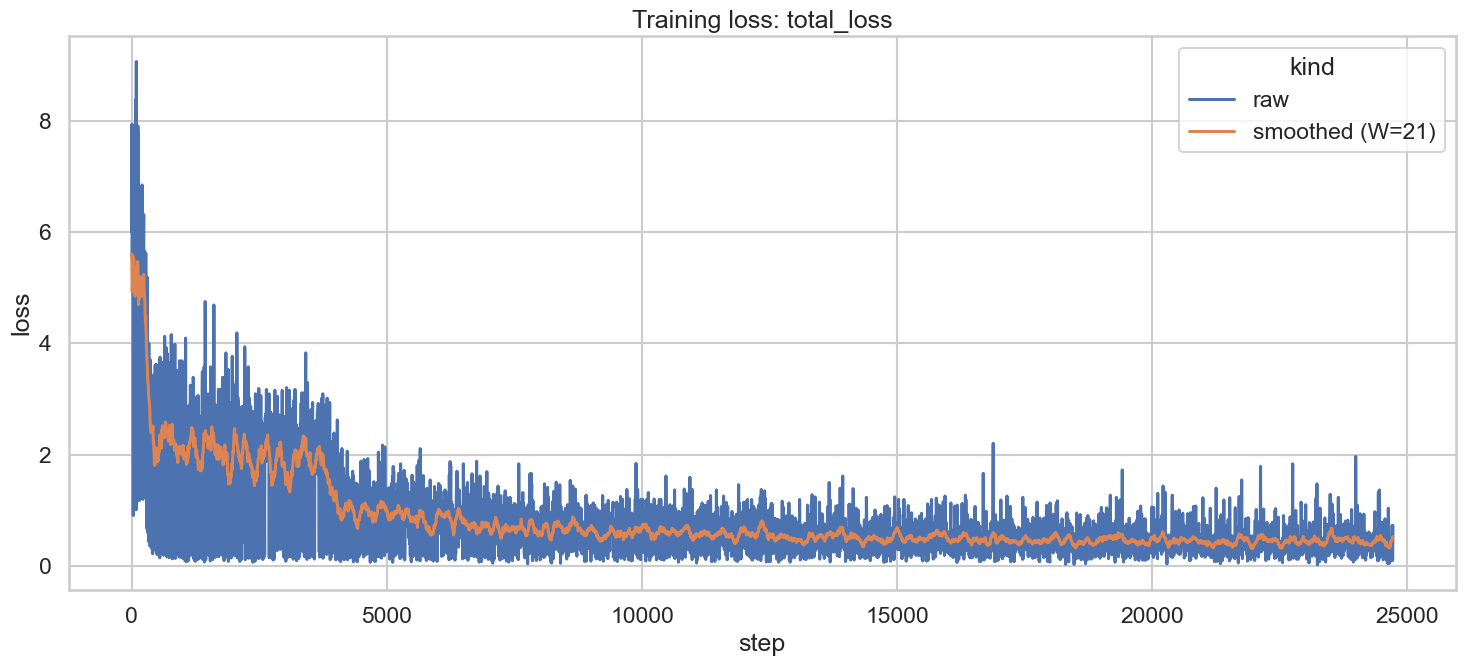

Saved: figures/loss_total_loss.png


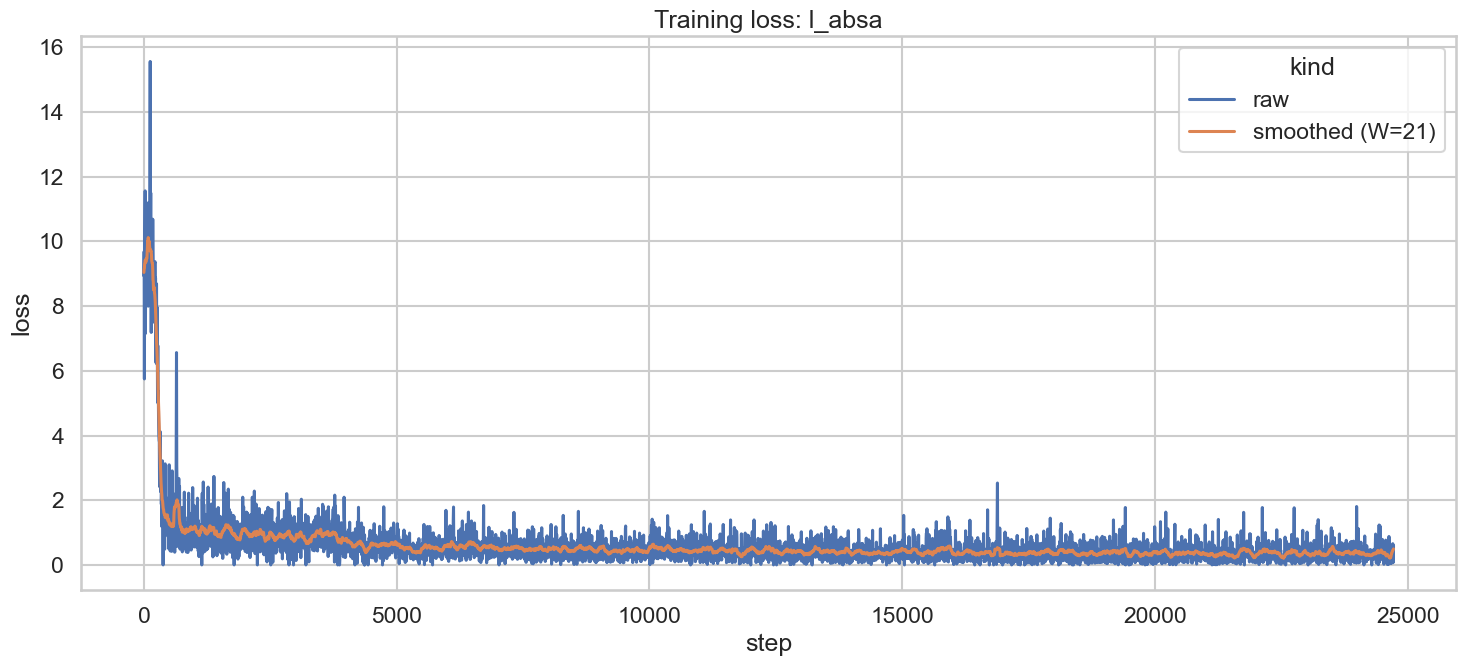

Saved: figures/loss_l_absa.png


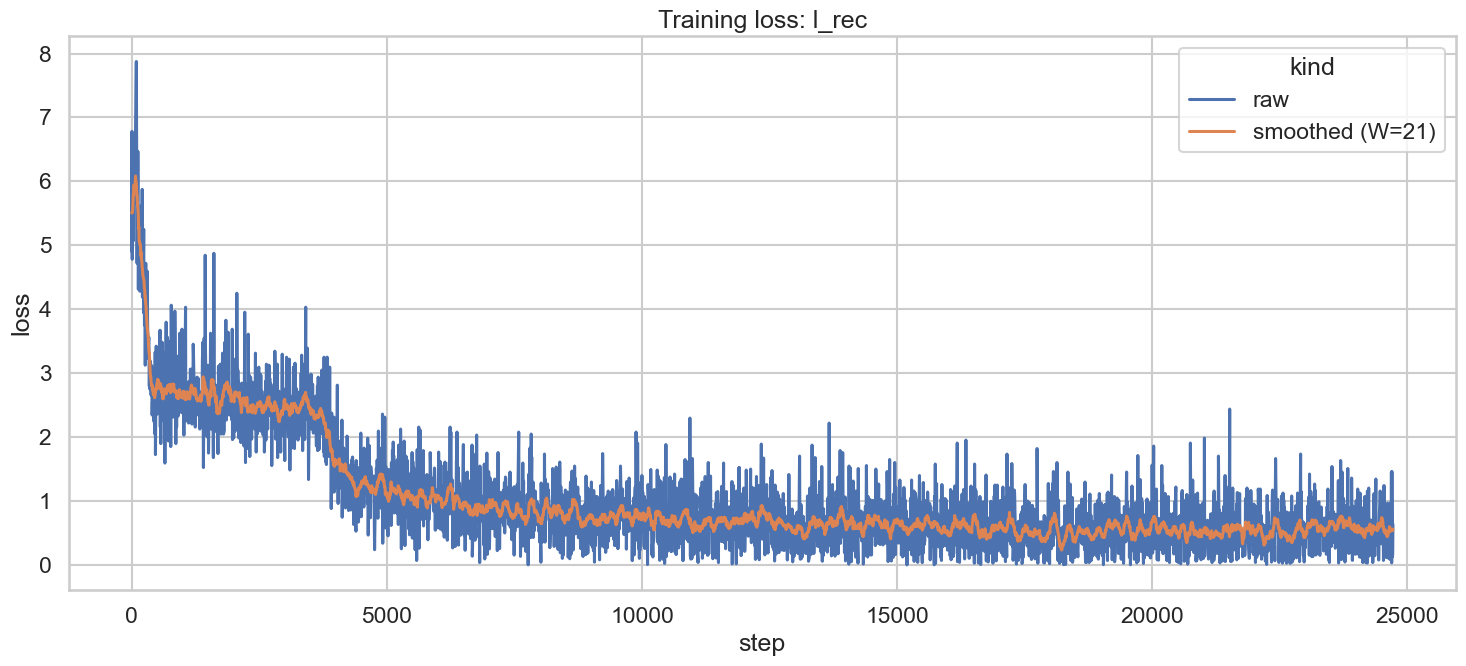

Saved: figures/loss_l_rec.png


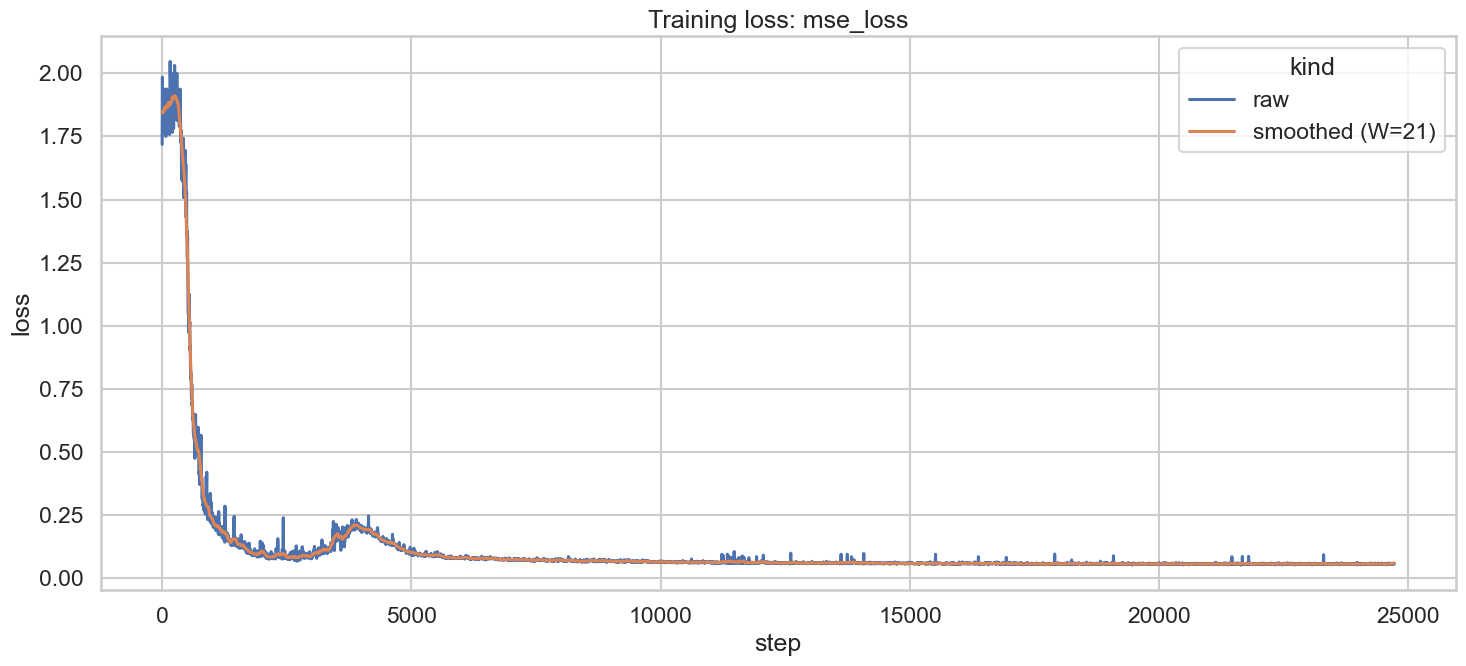

Saved: figures/loss_mse_loss.png


In [7]:
metrics_to_plot = ["total_loss", "l_absa", "l_rec", "mse_loss"]

for m in metrics_to_plot:
    plot_df = loss_long[loss_long["metric"] == m].dropna(subset=["value"])

    plt.figure(figsize=(15, 7))
    ax = sns.lineplot(
        data=plot_df,
        x="step", y="value",
        hue="kind",
        linewidth=2.2
    )
    ax.set_title(f"Training loss: {m}")
    ax.set_xlabel("step")
    ax.set_ylabel("loss")

    plt.tight_layout()
    out = OUT_DIR / f"loss_{m}.png"
    plt.savefig(out, dpi=300)
    plt.show()
    print("Saved:", out)

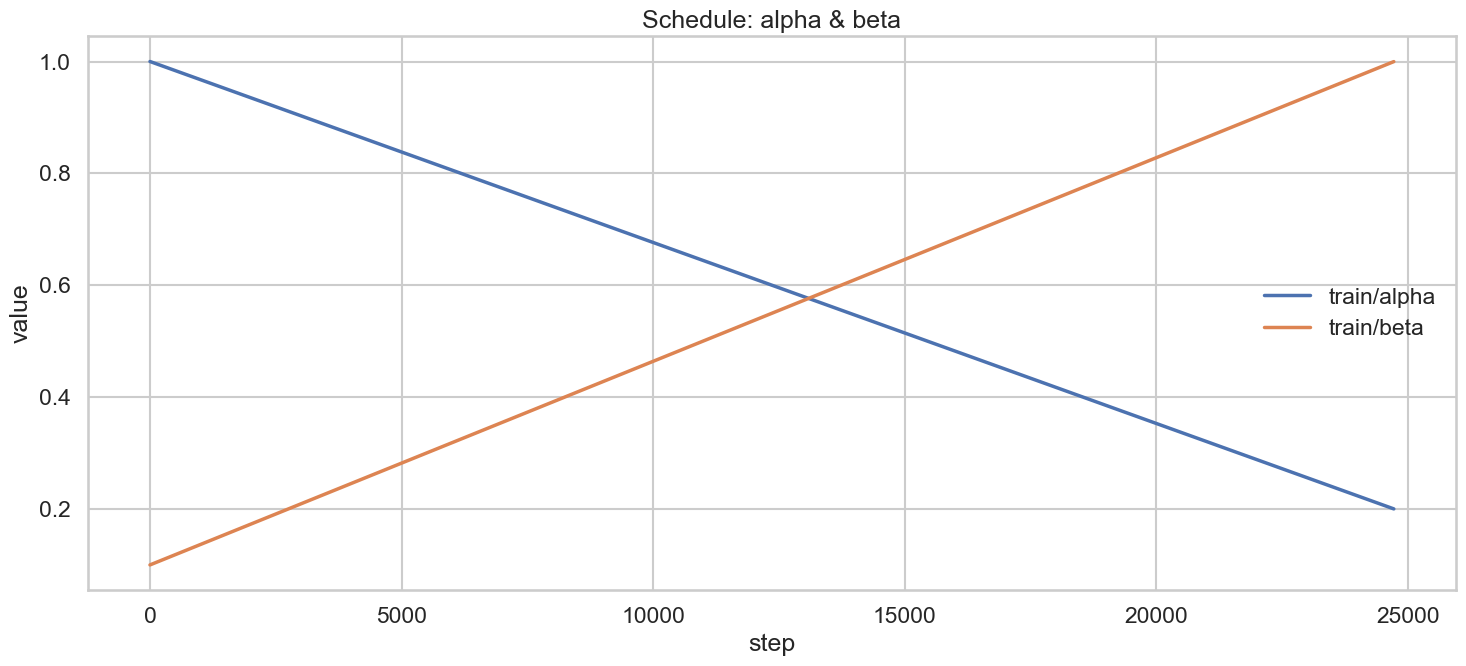

In [9]:
df_ab = pd.melt(
    df,
    id_vars="step",
    value_vars=["train/alpha", "train/beta"],
    var_name="param",
    value_name="value"
)

plt.figure(figsize=(15, 7))

ax = sns.lineplot(
    data=df_ab,
    x="step",
    y="value",
    hue="param",
    linewidth=2.5
)

ax.set_title("Schedule: alpha & beta")
ax.set_xlabel("step")
ax.set_ylabel("value")

ax.legend(frameon=False)

plt.tight_layout()
out = OUT_DIR / "param_alpha_beta.png"
plt.savefig(out, dpi=300)
plt.show()


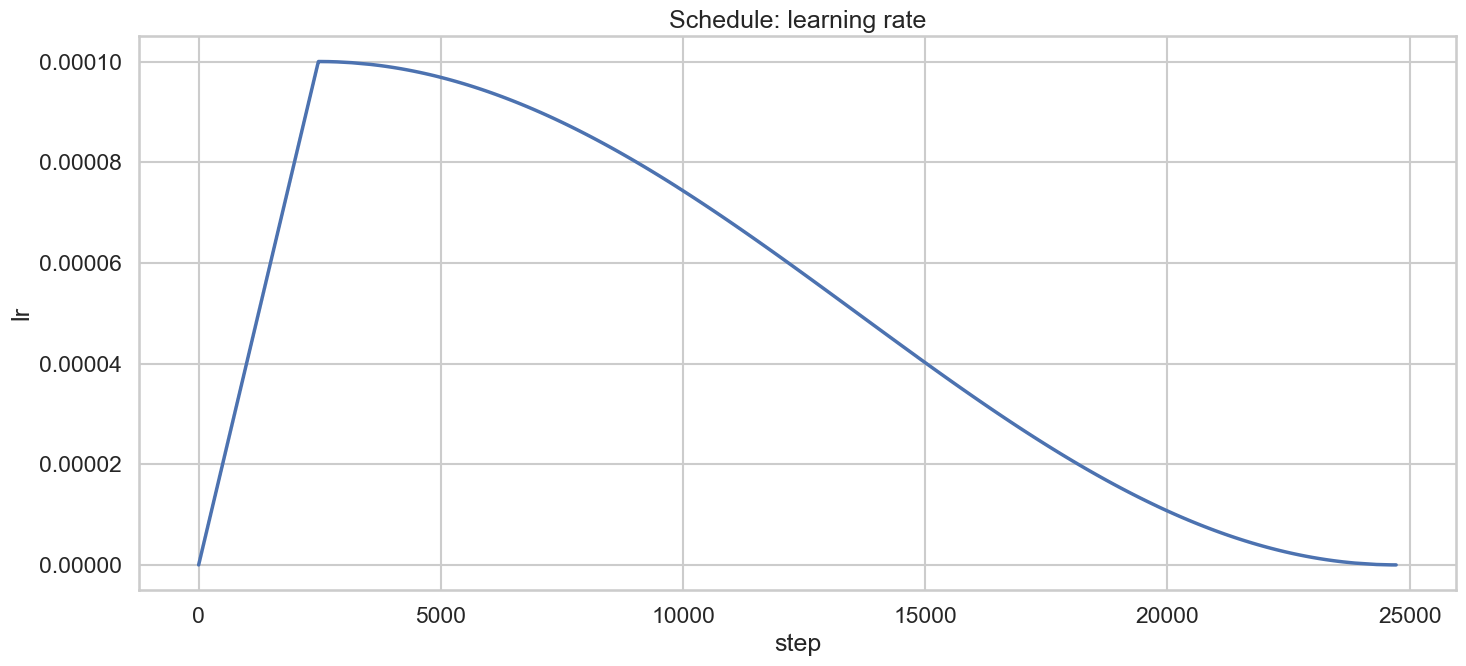

Saved: figures/param_lr_linear.png


In [10]:
plt.figure(figsize=(15, 7))

ax = sns.lineplot(
    data=df,
    x="step",
    y="train/lr",
    linewidth=2.5
)

ax.set_title("Schedule: learning rate")
ax.set_xlabel("step")
ax.set_ylabel("lr")

plt.tight_layout()
out = OUT_DIR / "param_lr_linear.png"
plt.savefig(out, dpi=300)
plt.show()

print("Saved:", out)